In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.stats import norm,lognorm
from itertools import permutations
from scipy import linalg,optimize

# Quelques définitions

In [40]:
class combined_distribution:
    def __init__(self,dists,weigths):
        self.dists = dists
        self.weights = weigths / weigths.sum()
    
    def pdf(self,x):
        pdfs = np.array([dist.pdf(x) for dist in self.dists])
        return np.dot(self.weights,pdfs)
    
    def cdf(self,x):
        pdfs = np.array([dist.cdf(x) for dist in self.dists])
        return np.dot(self.weights,pdfs)
    
    def cdf_inv(self,u):
        res = optimize.minimize_scalar(lambda x: (self.cdf(x)-u)**2)
        return res.x
    
    def sample(self,n):
        n_repartition = np.round(self.weights * n).astype(int)
        samples = [dist_i.ppf(np.random.rand(n_i)) for (dist_i,n_i) in zip(dists,n_repartition)]
        return np.concatenate(samples)
    
    def mean(self):
        means = [dist.mean() for dist in dists]
        return np.dot(self.weights,means)
    
    def median(self):
        return self.cdf_inv(0.5)
    
    def var(self):
        samples = np.random.random(1000)
        return np.mean(np.square(samples)) - np.square(samples.mean())
    
    def std(self):
        return np.sqrt(self.var())
    
    def sample_mean_dist(self,n):
        std_estimation = self.std() / np.sqrt(n)
        return norm(loc= self.mean(),scale= std_estimation)

# Exemple de distribution

In [41]:
dists = np.array([norm(loc=-2),norm(loc=0,scale=0.5),norm(loc=4,scale=2)])
weights = np.array([3,2,5])
complex_dist = combined_distribution(dists,weights)
print("Distribution Multi-modale")
for dist,weight in zip(complex_dist.dists,complex_dist.weights):
    print("N({},{}) x {}".format(dist.mean(),dist.var(),weight))

Distribution Multi-modale
N(-2.0,1.0) x 0.3
N(0.0,0.25) x 0.2
N(4.0,4.0) x 0.5


In [42]:
print("Moyenne :",complex_dist.mean())
print("Median :",complex_dist.median())
print("Variance :",complex_dist.var())
print("Ecart-type :",complex_dist.std())

Moyenne : 1.4
Median : 0.6205849921014973
Variance : 0.08389962243264609
Ecart-type : 0.28376483589639495


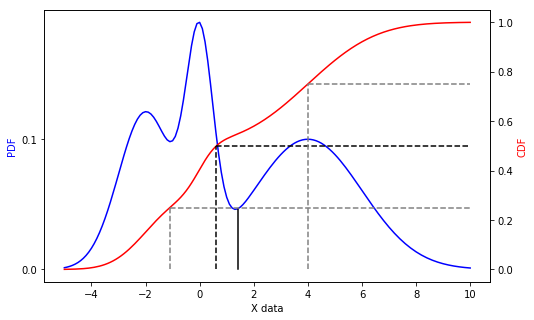

In [68]:
x = np.linspace(-5,10,151)
fig, ax1 = plt.subplots()
plt.yticks(np.arange(0,1,step=0.1))

ax2 = ax1.twinx()
ax1.plot(x, complex_dist.pdf(x), 'b-')
ax2.plot(x, complex_dist.cdf(x), 'r-')

ax1.set_xlabel('X data')
ax1.set_ylabel('PDF', color='b')
ax2.set_ylabel('CDF', color='r')


ax1.plot([complex_dist.mean()]*2,[0,complex_dist.pdf(complex_dist.mean())],color='k')
ax2.plot([complex_dist.median(),x.max()],[0.5,0.5],"k--")
ax2.plot([complex_dist.median()]*2,[0,0.5],color='k',linestyle="--")
ax2.plot([complex_dist.cdf_inv(0.25),x.max()],[0.25,0.25],"--",color="gray")
ax2.plot([complex_dist.cdf_inv(0.25)]*2,[0,0.25],color='gray',linestyle="--")
ax2.plot([complex_dist.cdf_inv(0.75),x.max()],[0.75,0.75],"--",color="gray")
ax2.plot([complex_dist.cdf_inv(0.75)]*2,[0,0.75],color='gray',linestyle="--")

fig.set_size_inches((8,5))

In [85]:
@interact(n=widgets.IntSlider(min=2,max=300,stp=1,value=10,continuous_update=False))
def interact_sampling(n):
    sample = complex_dist.sample(n)
    
    fig, ax1 = plt.subplots()
    x = np.linspace(-5,10,151)
    ax1.set_xlim(-5,10)

    plt.yticks(np.arange(0,1,step=0.1))
    ax2 = ax1.twinx()
    ax1.set_ylim(0,0.2)
    ax2.set_ylim(0,1)

    ax1.hist(sample,density=True,bins=20,zorder=1)
    ax2.hist(sample,cumulative=True,density=True,bins=20,histtype="step",facecolor=None,edgecolor="red",zorder=0)
    ax1.plot(x, complex_dist.pdf(x), 'k--')
    ax2.plot(x, complex_dist.cdf(x), 'k--')
    
    ax1.axvline(x=complex_dist.mean(),color='green',linestyle="-",ymax=1.0)
    ax1.axvline(x=sample.mean(),color='k',linestyle="--",ymax=0.9)

    ax1.set_xlabel('X data')
    ax1.set_ylabel('PDF', color='b')
    ax2.set_ylabel('CDF', color='r')
    fig.set_size_inches((8,5))

interactive(children=(IntSlider(value=10, continuous_update=False, description='n', max=300, min=2), Output())…